In [92]:
# import
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import seaborn as sns
import imageio
import os 
import scipy.stats as stats 

In [93]:
#Parameters
plots_folder = "/Users/alexandranava/Desktop/EmbryonicCells/Plots/"
Tsim = 20 #number of minutes to run simulation
dt = 1 # minutes between each simulation step 
N = int(Tsim/dt) # Number of iterations to run 
noise_std = 0.001
print(f"running {N} simulations...")
div_k = 7.5
div_theta = 1.2

#num of each species to start with
A_cells = 1
B_cells = 2
C_cells = 3


a_a, a_b, a_c = [1, 2, 0.0]
b_a, b_b, b_c = [1, 1, 0]
c_a, c_b, c_c = [0, 0, 5]

#pixels in simulation: 
x_pixels = 100
y_pixels = 100

#radius in px 
A_radius = 5
B_radius = 8
C_radius = 10

env_r = x_pixels/2

running 20 simulations...


In [94]:
def is_in_boundary(cell_position: list[int], r_env = 5):
  '''
  Parameters: 
  r: radius of defined region for cells
  cell_position: list for a single cell with x and y position
  Return: 
  true: within region
  false: exited region
  '''
  x = cell_position[0]
  y = cell_position[1]

  if np.sqrt(x**2 + y**2) < r_env:
    return True
  else: 
    return False


def calculate_cartesian_coords(theta, r):
  cos = np.cos(theta)
  sin = np.sin(theta)
  x = cos*r
  y = sin*r
  return [x, y]

def calculate_polar_coords(x, y):
  r = np.sqrt(x**2 + y**2)
  theta = np.arctan2(y, x)
  return [theta, r]

In [95]:
df_parameters = pd.DataFrame({
  "to": ["A", "B", "C", "radius"],
  "A": [a_a, a_b, a_c, A_radius], #top
  "B": [b_a, b_b, b_c, B_radius], # middle
  "C": [c_a, c_b, c_c, C_radius] #outer edge
  
}).set_index("to")

print(df_parameters)

          A  B   C
to                
A       1.0  1   0
B       2.0  1   0
C       0.0  0   5
radius  5.0  8  10


In [96]:
#randomize initial cell positions
cell_theta_init = np.random.uniform(0, 90, A_cells + B_cells + C_cells)
cell_dist_init = np.random.uniform(0, env_r, A_cells + B_cells + C_cells)

coordinates = [calculate_cartesian_coords(theta, dist) for theta, dist in zip(cell_theta_init, cell_dist_init)]
xs_init, ys_init = zip(*coordinates)



#create dataframe
df = pd.DataFrame({
  "cell_numbers":  list(range(0, A_cells)) + list(range(0, B_cells)) + list(range(0, C_cells)),
  "species": ["A" for tmp in range(0, A_cells)] + ["B" for tmp in range(0, B_cells)] + ["C" for tmp in range(0, C_cells)],
  "timestep": [0 for tmp in range(0, A_cells + B_cells + C_cells)],
  "x":  xs_init,
  "y": ys_init,
  "radius": [A_radius for tmp in range(0, A_cells)] + [B_radius for tmp in range(0, B_cells)] + [C_radius for tmp in range(0, C_cells)],
  "time_to_division": np.random.gamma(shape = div_k, scale = div_theta, size = A_cells + B_cells + C_cells)
  })


In [97]:
def sp_attracting(cell1_data, cell2_data, attraction_coef: int):
  '''behavior of cells attracting/repelling
    returns x,y position of next position for cell1, ignoring boundary 
  '''

  x_main = cell1_data["x"]
  y_main = cell1_data["y"]
  size_main = cell1_data["radius"]

  x_to  = cell2_data["x"]
  y_to = cell2_data["y"]
  size_to = cell2_data["radius"]

  #distance used for normalization
  distance = np.sqrt((x_to - x_main)**2 + (y_to - y_main)**2)

  x_direction = (x_to - x_main) / distance
  y_direction = (y_to - y_main) / distance

  #scale attraction coefficient by distance
  #attraction_coef = attraction_coef / distance  # use this for stronger attraction/repulsion to closer ones 

  #new coordinates 
  x_next = x_main + attraction_coef * x_direction + np.random.normal(0, noise_std) - x_main
  y_next = y_main + attraction_coef * y_direction + np.random.normal(0, noise_std) - y_main

  #check if new cell positions overlap 
  distance_new = np.sqrt((x_to - x_next)**2 + (y_to - y_next)**2)

  #if overlap, return previous positions
  if distance_new < size_main + size_to:
    return [np.random.normal(0, noise_std), np.random.normal(0, noise_std)]

  return [x_next, y_next]

In [98]:
def time_to_divide(df, cell, k, theta, i):
  time_to_divide = cell["time_to_division"]

  if time_to_divide <= 0:
    # if division occurs 
    x_cell = cell["x"]
    y_cell = cell["y"]
    species = cell["species"]

    new_cell_num = len(df[(df["timestep"] == i) & (df["species"] == species)])

    new_cell = ({
        "cell_numbers": new_cell_num,
        "timestep": i + 1,
        "species": species, 
        "x": x_cell + np.random.normal(0, noise_std),
        "y": y_cell + np.random.normal(0, noise_std),
        "parent_cell_ids": cell,
        "radius": cell["radius"],
        "time_to_division": np.random.gamma(shape = k, scale = theta, size = 1)
    })
    df.loc[len(df)] = new_cell
    time_to_divide = np.random.gamma(shape = k, scale = theta, size = 1)
    return df, time_to_divide
  
  if time_to_divide != 0:
    time_to_divide -= dt
    return df, time_to_divide  #updated time after this step  

Grid

In [99]:
from skimage.draw import disk
def mask_cell_area(x: float, y:float, r:float, env_x, env_y):
  '''
  x: center of cell in pixels
  y: center of cell in pixels
  r: radius of cell in pixels 
  '''
  size = (env_x, env_y)
  image = np.zeros(size, dtype = np.uint8)
  rr, cc, = disk((y + env_y/2, x + env_x/2), r/2, shape = image.shape)
  image[rr, cc] = 1
  # returns binary matrix where input cell location has 1s 
  return image 

def print_mask(t, binary_matrix, x_pixels, y_pixels):

  # Plot the binary matrix
  plt.imshow(binary_matrix, cmap='Greys', vmin = 0, vmax = 5, interpolation='nearest', origin='lower', alpha = 0.5)
  plt.colorbar(label="Value (0 or 1)")
  plt.title(rf"Time = {t}")


  plt.axvline(x_pixels/2, linestyle = "--", color = "lightgrey")
  plt.axhline(y_pixels/2, linestyle = "--", color = "lightgrey")
  # Display the grid
  plt.show()


### MAIN

running timestep 0...


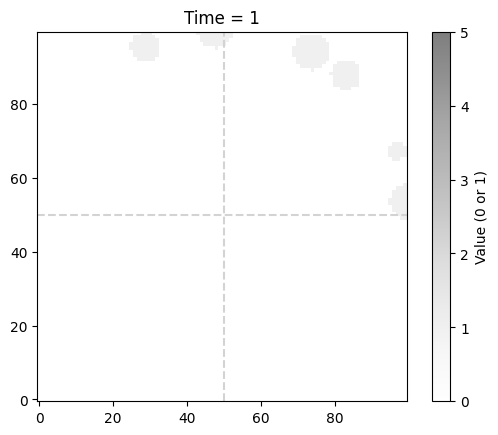

running timestep 1...


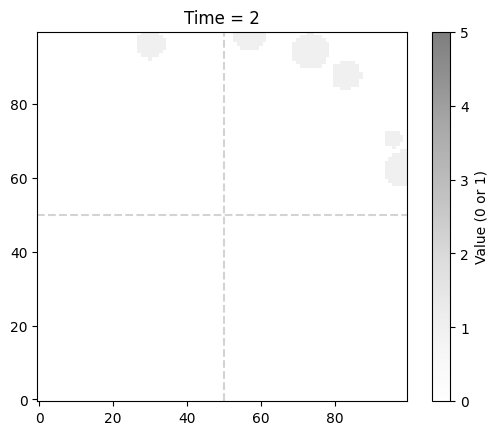

running timestep 2...


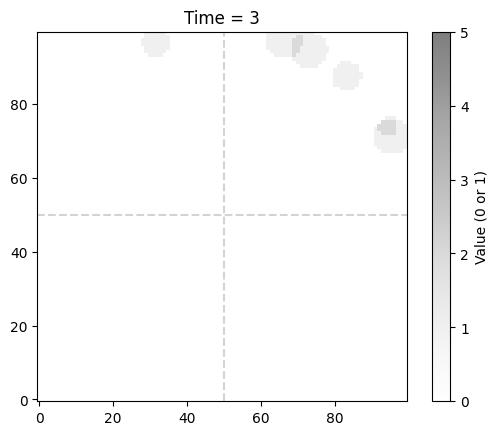

overlap!
running timestep 3...


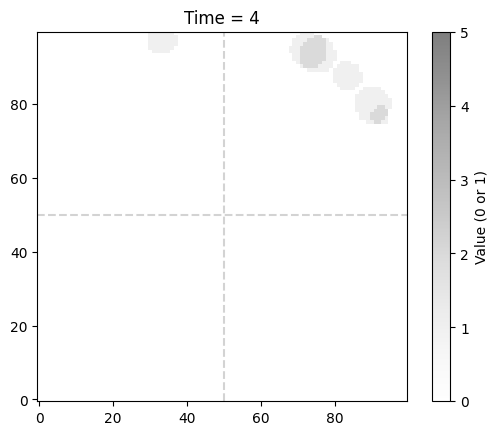

overlap!
running timestep 4...


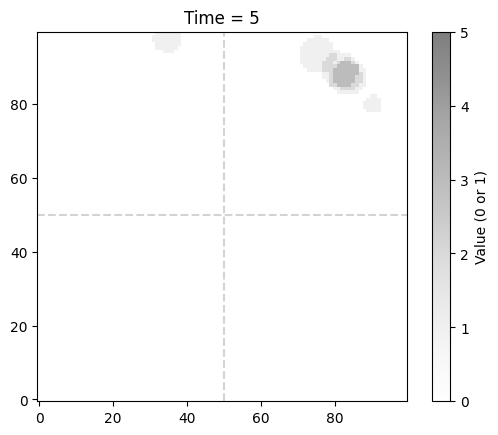

overlap!
running timestep 5...


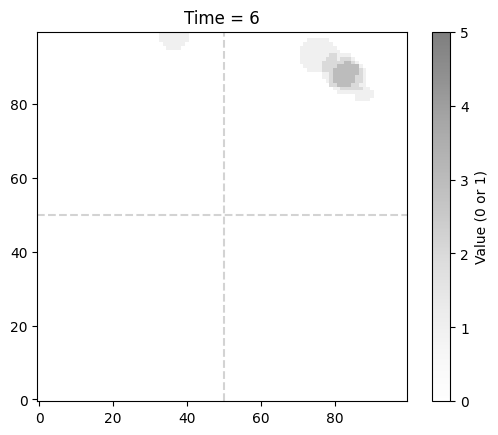

overlap!
running timestep 6...


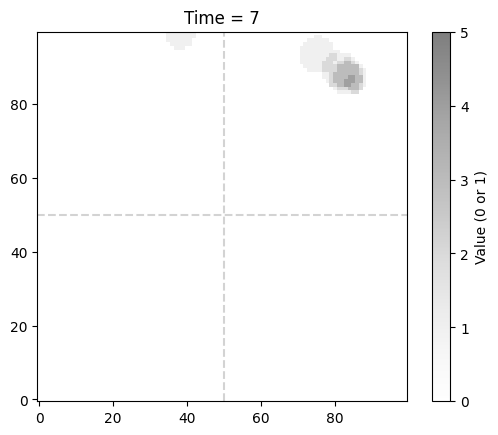

overlap!
running timestep 7...


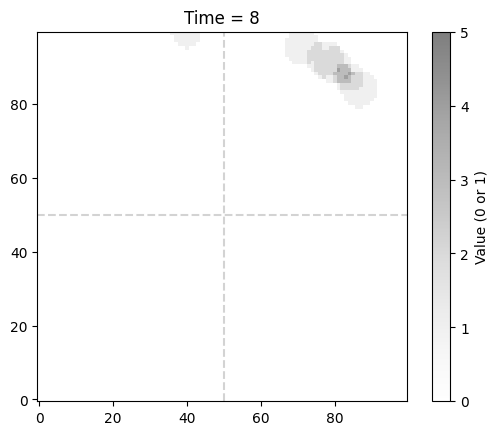

overlap!
running timestep 8...


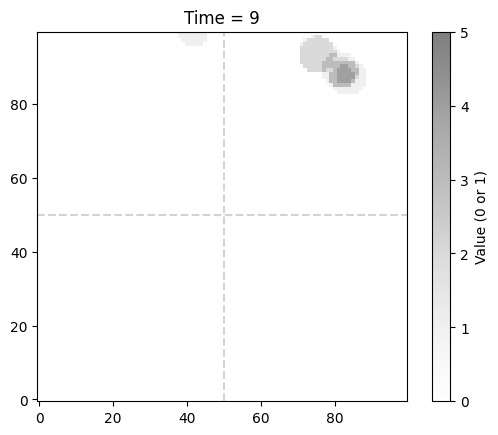

overlap!
running timestep 9...


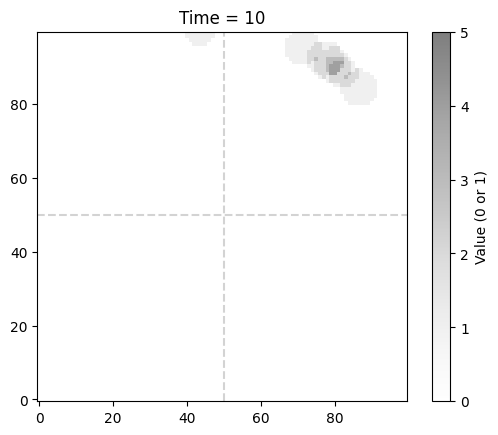

overlap!
running timestep 10...


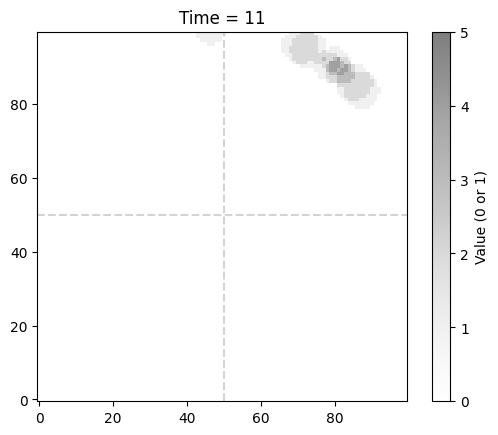

overlap!
running timestep 11...


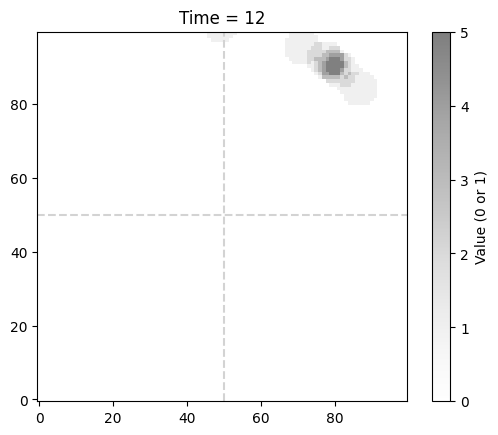

overlap!
running timestep 12...


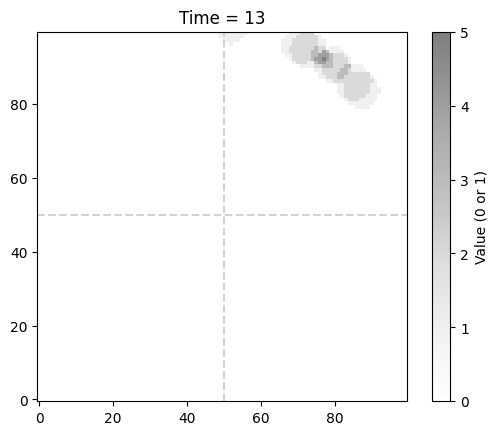

overlap!
running timestep 13...


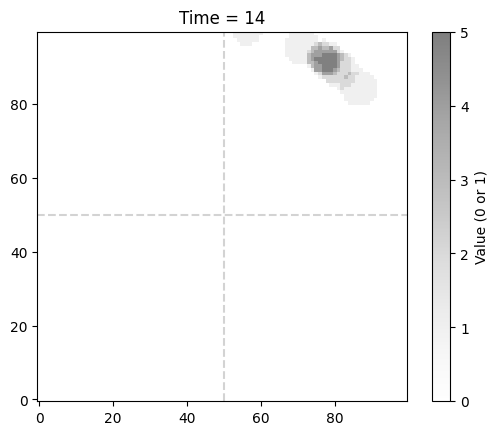

overlap!
running timestep 14...


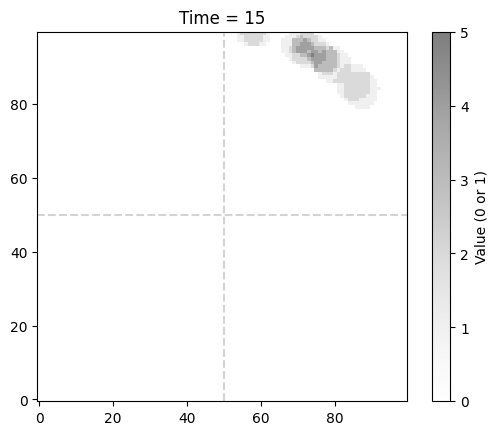

overlap!
running timestep 15...


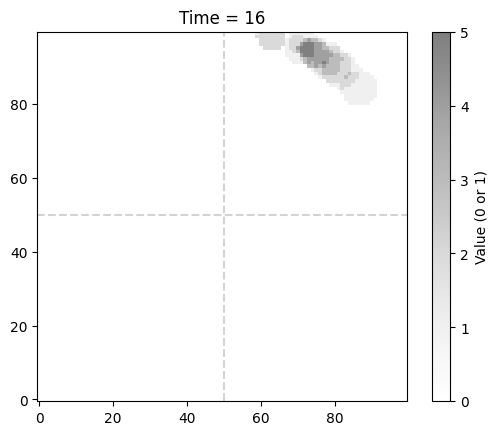

overlap!
running timestep 16...


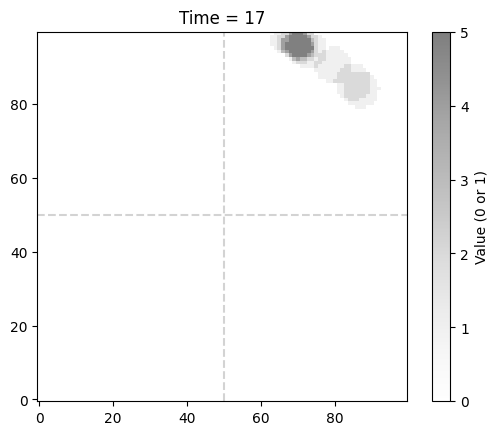

overlap!
running timestep 17...


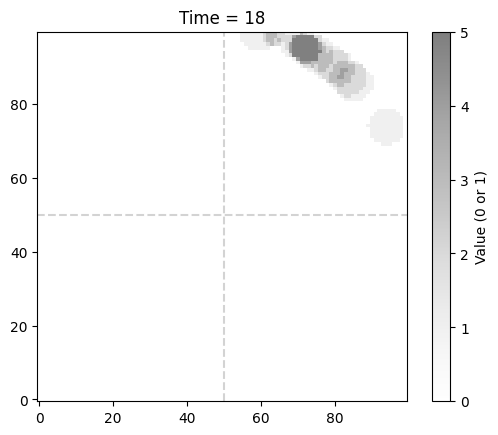

overlap!
running timestep 18...


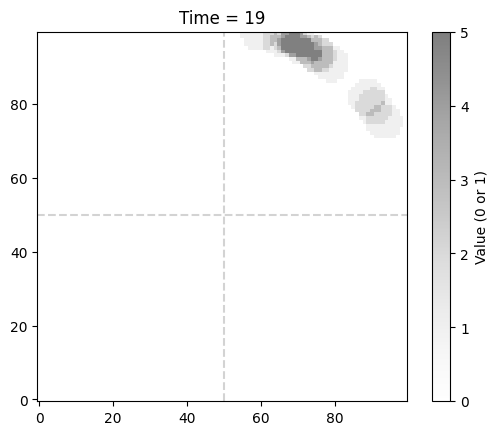

overlap!
running timestep 19...


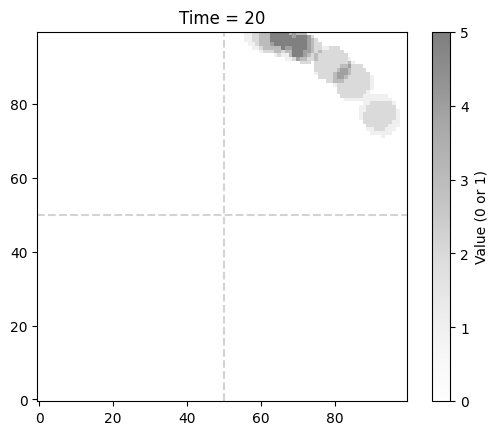

overlap!


In [100]:

pop_area_array = np.zeros((x_pixels, y_pixels))
for i in range(0, N):
  print(fr"running timestep {i}...")
  pop_area_array = np.zeros((x_pixels, y_pixels))

  df_t = df[df["timestep"] == i] # grab current timesteps from df
  #find resulting vector after attraction repulsion of every other cell
  for row_index, cell in df_t.iterrows(): 
    df, time_to_division = time_to_divide(df, cell, div_k, div_theta, i)
    cell_sp = cell["species"] # main cell sp 
    attraction_vectors = [] # all pulling vectors
    
    #iterate through other cells
    df_other_cells_t = df_t[(df_t["cell_numbers"] != cell["cell_numbers"]) | (df_t["species"] != cell_sp)]
    for _, cell2_t in df_other_cells_t.iterrows(): 
  
      cell2_sp = cell2_t["species"] # second cell sp

      attraction_rate = df_parameters.loc[cell2_sp, cell_sp]
      displacement = sp_attracting(cell, cell2_t, attraction_rate) # result of a single cell pulling it  
      attraction_vectors.append(displacement)
      
    # new position for main cell
    new_x = sum(vector[0] for vector in attraction_vectors) + cell["x"]+ np.random.normal(0, noise_std) # total displacement plus original x
    new_y = sum(vector[1] for vector in attraction_vectors) + cell["y"]+ np.random.normal(0, noise_std) # total displacement plus original y
    #if main leaves boundary, shorten magnitude to environment radius
    if not is_in_boundary([new_x, new_y]):
      theta, r = calculate_polar_coords(new_x, new_y)
      inboundary_coords = calculate_cartesian_coords(theta, env_r)
      new_x, new_y = inboundary_coords[0], inboundary_coords[1]
    
    # CALC NEW AREA OF CELL AND APPEND TO POP MATRIX
    cell_area_array = mask_cell_area(new_x, new_y, cell["radius"], x_pixels, y_pixels)
    pop_area_array += cell_area_array

    # add new row to data 
    df.loc[len(df)] = {
      "cell_numbers": cell["cell_numbers"],
      "species": cell_sp,
      "timestep": i+1,
      "x": new_x,
      "y": new_y,
      "radius": cell["radius"],
      "time_to_division": time_to_division
    }

  # CHECK IF NEW MATRIX HAS ANY 2s 
  print_mask(i+1, pop_area_array, x_pixels, y_pixels)
  if 2 in pop_area_array:
    print("overlap!")

  #            

## Plot

/var/folders/hf/27j9pt1n18901_qs25pdn5cc0000gn/T/ipykernel_69900/737238075.py:77: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(frame)


GIF saved as /Users/alexandranava/Desktop/EmbryonicCells/Plots/simulation.gif


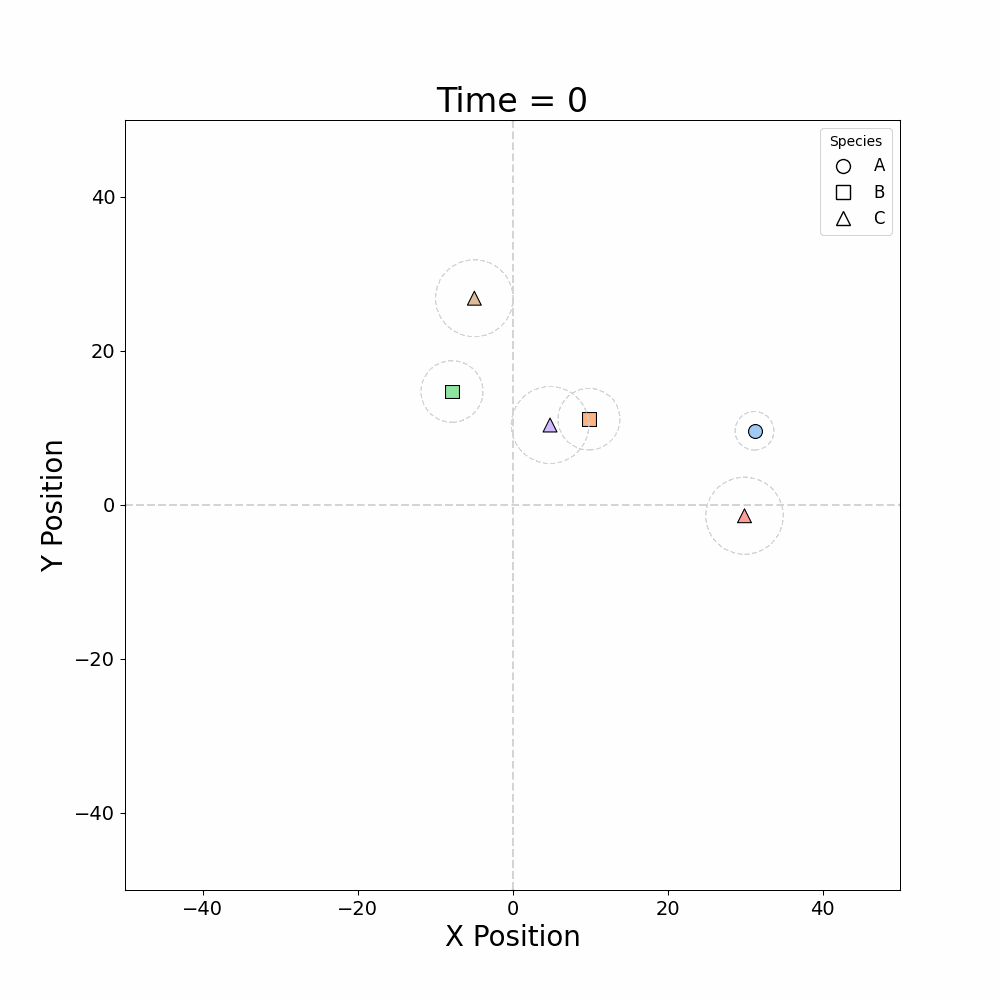

In [101]:
import matplotlib.lines as mlines
from IPython.display import Image, display

def embryos_gif():
    frames = []
    markers = {'A': 'o', 'B': 's', 'C': '^'}  # Customize markers for each species

    df['unique_id'] = df['species'].astype(str) + "_" + df['cell_numbers'].astype(str)

    unique_ids = df['unique_id'].unique()
    id_palette = sns.color_palette("pastel", len(unique_ids))  # Generate color palette
    id_color_map = dict(zip(unique_ids, id_palette))

    for t in range(N+1):
        plt.figure(figsize=(10, 10))

        # DATA at TIMESTEP t
        timestep_data = df[df["timestep"] == t]

        
        sp_groups = timestep_data.groupby("species")
        for species, group in sp_groups:
            sns.scatterplot(
                x="x", 
                y="y", 
                data=group, 
                hue="unique_id", 
                marker=markers.get(species, 'o'),  
                palette=id_color_map,
                s=100, 
                edgecolor="black", 
                legend=None
            )

        # BOUNDARIES FOR EACH CELL
        for _,cell_row in timestep_data.iterrows():
            x, y = cell_row["x"], cell_row["y"]
            radius = df_parameters.loc["radius", cell_row["species"]]
            cell_boundary = plt.Circle((x, y), radius/2, edgecolor="lightgrey", linestyle="--", facecolor="none", zorder=2)
            plt.gca().add_patch(cell_boundary)

        # ENVIRONMENT BOUNDARY
        #env_boundary = plt.Circle((0, 0), env_r, edgecolor='lightgrey', facecolor='none', linewidth=2, label="experiment boundary", alpha = 0.8)
        #plt.gca().add_patch(env_boundary)

        # LABELING
        t_min = t * dt 
        plt.title(rf"Time = {t_min}", fontsize=24)
        plt.axvline(0, linestyle="--", color="lightgrey")
        plt.axhline(0, linestyle="--", color="lightgrey")
        plt.xlim(-env_r, env_r)
        plt.ylim(-env_r, env_r)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.xlabel("X Position", fontsize=20)
        plt.ylabel("Y Position", fontsize=20)
        #plt.legend(loc="upper right", fontsize=14)

        # MARKERS
        legend_elements = [
                    mlines.Line2D([0], [0], marker=marker, markeredgecolor="black", markerfacecolor = "none", 
                                label=species, markersize=10, linestyle="None") 
                    for i, (species, marker) in enumerate(markers.items())
                ]
        plt.legend(handles=legend_elements, title="Species", loc="upper right", fontsize=12)

        # SAVE ith FRAME
        filename = f"frame_{t}.png"
        plt.savefig(filename)
        plt.close()
        frames.append(filename)

    # CREATE GIF
    gif_path = os.path.join(plots_folder, 'simulation.gif')
    with imageio.get_writer(gif_path, mode='I', duration=40) as writer:
        for frame in frames:
            image = imageio.imread(frame)
            writer.append_data(image)

    # CLEAN FRAMES
    for frame in frames:
        os.remove(frame)

    print(f"GIF saved as {gif_path}")
    return gif_path  # Return the path to the GIF

#display gif 
gif_path = embryos_gif()
display(Image(filename=gif_path))

#print(df_parameters)

In [102]:
def plot_division_prob(k, theta, Tsim, dt):
  ts = np.arange(0, Tsim + dt, dt)
  distribution = stats.gamma.pdf(ts, a = k, scale = theta)

  plt.plot(ts, distribution)
  plt.scatter(ts, distribution, facecolors='none', edgecolors='b', s=100)
  
  plt.xlabel("Time (min)")
  plt.ylabel("Probability of Division")
  plt.title(rf"Gamma Distribution with $\alpha = {k}$, $\theta = {theta}$")
  plt.show()
  return max(distribution)
#max_prob = plot_division_prob(div_k, div_theta, Tsim, dt)
